
# Electron Plasma Waves

Created by Rui Calado and Jorge Vieira, 2018

In this notebook, we are going to study the dispersion relation for electron plasma waves.

## Theory

Electron plasma waves are longitudinal waves that may propagate in unmagnetized plasmas. To derive the dispersion relation for such waves let us start by considering the following setup:
* $\nabla\times\mathbf{E}=0$ (Longitudinal waves)
* $T_i=T_e=0$ (Cold plasma)
* $\mathbf{B}=0$ (Unmagnetized)

We start by writing the continuity and momentum equations for the electron and ion species:

$$\large \left\{\begin{array}{lcr}
        \frac{\partial n_{e,i}}{\partial t}+\nabla\cdot(n_{e,i}\mathbf{v}_{e,i})=0 \\
        \frac{\partial \mathbf{v}_{e,i}}{\partial t}=\mp \frac{e}{m_{e,i}}\mathbf{E}\\
        \end{array}\right. .
$$

Then we consider Poisson's equation:

$$\epsilon_0\nabla\cdot\mathbf{E}=e(n_i-n_e).$$

Applying a time derivative twice,

$$\epsilon_0\nabla\cdot\left(\frac{\partial^2 \mathbf{E}}{\partial t^2}\right)=e\left(\frac{\partial^2n_i}{\partial t^2}-\frac{\partial^2n_e}{\partial t^2}\right).$$

Using the continuity and momentum equations we get:

$$\frac{\partial^2 \mathbf{E}}{\partial t^2}-\frac{e^2n_0}{\epsilon_0}\left(\frac{1}{m_i}+\frac{1}{m_e}\right)\mathbf{E}=0.$$

This is the equation for a harmonic oscillator. Neglecting the $1/m_i$ term since $m_e\ll m_i$, our oscillation frequency is the electron plasma frequency:

$$\omega=\frac{e^2n_0}{\epsilon_0 m_e}\equiv \omega_{p}.$$

### Warm plasma

Now, what happens if we consider a warm plasma instead? Neglecting ion motion, the first step is to add a pressure term to the electron momentum equation:

$$\frac{\partial \mathbf{v}_{e}}{\partial t}=- \frac{e}{m_{e}}\mathbf{E}-\frac{\gamma k_BT_e}{m_en_0}\nabla n_1.$$

We also note that Poisson's equation now takes the form:

$$\nabla\cdot\mathbf{E}=-\frac{e}{\epsilon_0}n_1.$$

Taking the divergence of the momentum equation, we get:

$$\nabla\cdot\left( \frac{\partial \mathbf{v}}{\partial t} \right)=-\frac{e}{m_e}\nabla\cdot\mathbf{E}-\frac{\gamma kT_e}{m_en_0}\nabla\cdot  (\nabla n_e).$$

Using the unchanged continuity equation and Poisson's equation:

$$\frac{\partial^2n_1}{\partial t^2}+\omega_{p}^2n_1-\frac{\gamma k_BT_e}{m_e}\nabla\cdot(\nabla n_1)=0.$$

Considering the high frequency regime, there will be no heat losses in our time scale, and so we will take the adiabatic coefficient $\gamma=3$ for 1D longitudinal oscillations. Additionally, we use the definition $v_{th}^2=k_BT_e/m_e$ to write:

$$\frac{\partial^2n_1}{\partial t^2}+\omega_{p}^2n_1-3v_{th}^2\nabla\cdot(\nabla n_1)=0.$$

The final step consists of considering sinusoidal waves such that $n_1=\text{n}_1\exp^{i(\mathbf{k}\cdot\mathbf{r}-\omega t)}$ and then Fourier analyzing the equation $\left(\nabla=i\mathbf{k},\ \frac{\partial}{\partial t}=-i\omega \right)$, which results in the dispersion relation:

$$\omega^2=\omega_{p}^2+3v_{th}^2k^2.$$

## Simulations with ZPIC

In [24]:
import em1ds as zpic

#v_the = 0.001
v_the = 0.02
#v_the = 0.20

electrons = zpic.Species( "electrons", -1.0, ppc = 64, uth=[v_the,v_the,v_the])
sim = zpic.Simulation( nx = 500, box = 50.0, dt = 0.0999/2, species = electrons )

#sim.filter_set("sharp", ck = 0.99)
sim.filter_set("gaussian", ck = 50.0)

We run the simulation up to a fixed number of iterations, controlled by the variable `niter`, storing the value of the EM field $E_z$ at every timestep so we can analyze them later:

In [25]:
import numpy as np

niter = 4000

Ex_t = np.zeros((niter,sim.nx))
Ez_t = np.zeros((niter,sim.nx))

tmax = niter * sim.dt

print("\nRunning simulation up to t = {:g} ...".format(tmax))
while sim.t <= tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ex_t[sim.n,:] = sim.emf.Ex
    Ez_t[sim.n,:] = sim.emf.Ez
    sim.iter()

print("\nDone.")


Running simulation up to t = 199.8 ...
n = 3999, t = 199.751
Done.


## Electrostatic / Electromagnetic Waves

As discussed above, the simulation was initialized with a broad spectrum of waves through the thermal noise of the plasma. We can see the noisy fields in the plot below:

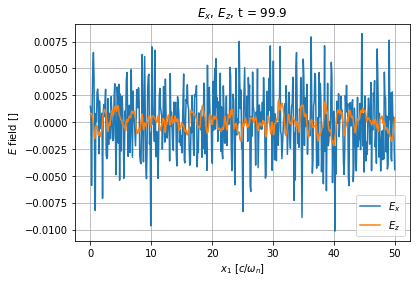

In [12]:
import matplotlib.pyplot as plt

iter = sim.n//2
plt.plot(np.linspace(0, sim.box, num = sim.nx),Ex_t[iter,:], label = "$E_x$")
plt.plot(np.linspace(0, sim.box, num = sim.nx),Ez_t[iter,:], label = "$E_z$")
plt.grid(True)

plt.xlabel("$x_1$ [$c/\omega_n$]")
plt.ylabel("$E$ field []")
plt.title("$E_x$, $E_z$, t = {:g}".format( iter * sim.dt))
plt.legend()
plt.show()

## Electrostatic Plasma Waves
To analyze the dispersion relation of the electrostatic plasma waves we use a 2D (Fast) Fourier transform of $E_x(x,t)$ field values that we stored during the simulation. The plot below shows the obtained power spectrum alongside the theoretical prediction.

Since the dataset is not periodic along $t$ we apply a windowing technique (Hanning) to the dataset to lower the background spectrum, and make the dispersion relation more visible.

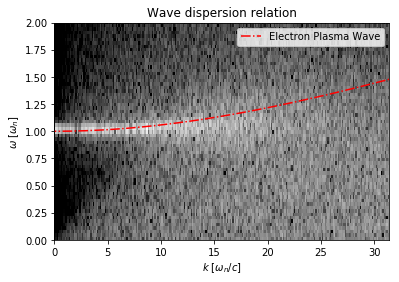

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# (omega,k) power spectrum

win = np.hanning(niter)
for i in range(sim.nx):
    Ex_t[:,i] *= win

sp = np.abs(np.fft.fft2(Ex_t))**2
sp = np.fft.fftshift( sp )

k_max = np.pi / sim.dx
omega_max = np.pi / sim.dt

plt.imshow( sp, origin = 'lower', norm=colors.LogNorm(vmin = 1e-1),
           extent = ( -k_max, k_max, -omega_max, omega_max ),
           aspect = 'auto', cmap = 'gray')

k = np.linspace(-k_max, k_max, num = 512)
w=np.sqrt(1 + 3 * v_the**2 * k**2)
plt.plot( k, w, label = "Electron Plasma Wave", color = 'r',ls = '-.' )


plt.ylim(0,2)
plt.xlim(0,k_max)
plt.xlabel("$k$ [$\omega_n/c$]")
plt.ylabel("$\omega$ [$\omega_n$]")
plt.title("Wave dispersion relation")

plt.legend()

plt.show()


## Electromagnetic Plasma Waves
To analyze the dispersion relation of the electrostatic plasma waves we use a 2D (Fast) Fourier transform of $E_z(x,t)$ field values that we stored during the simulation. The plot below shows the obtained power spectrum alongside the theoretical prediction.

Since the dataset is not periodic along $t$ we apply a windowing technique (Hanning) to the dataset to lower the background spectrum, and make the dispersion relation more visible.

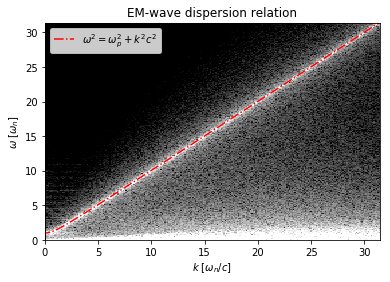

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# (omega,k) power spectrum

win = np.hanning(niter)
for i in range(sim.nx):
    Ez_t[:,i] *= win

sp = np.abs(np.fft.fft2(Ez_t))**2
sp = np.fft.fftshift( sp )

k_max = np.pi / sim.dx
omega_max = np.pi / sim.dt

plt.imshow( sp, origin = 'lower', norm=colors.LogNorm(vmin = 1e-7, vmax = 0.01),
           extent = ( -k_max, k_max, -omega_max, omega_max ),
           aspect = 'auto', cmap = 'gray')

k = np.linspace(-k_max, k_max, num = 512)
w=np.sqrt(1 + k**2)
plt.plot( k, w, label = "$\omega^2 = \omega_p^2 + k^2 c^2$", color = 'r', ls = '-.' )


plt.ylim(0,k_max)
plt.xlim(0,k_max)
plt.xlabel("$k$ [$\omega_n/c$]")
plt.ylabel("$\omega$ [$\omega_n$]")
plt.title("EM-wave dispersion relation")

plt.legend()

plt.show()